In [2]:
# Imports 
import spacy
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns

from spacy.util import minibatch, compounding
from spacy.training.example import Example
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Load data
with open('../nlpDataSet/train.json', 'r') as file:
    data = json.load(file)
with open('../nlpDataSet/test.json', 'r') as file:
    test_data = json.load(file)

# Training

In [19]:
def prepare_data(data):
    prepared_data = []
    for item in data:
        text = item['sentence']
        # We consider a travel when exactly two entities are present
        # We may modify this later to handle more complex travels with a list of checkpoints (like Nantes -> Paris -> Marseille)
        is_travel = len(item['entities']) == 2
        prepared_data.append((text, {"cats": {"TRAVEL": is_travel, "NOT_TRAVEL": not is_travel}}))
    return prepared_data
# Data preparation
train_data = prepare_data(data)
test_data = prepare_data(test_data)

num_positives = len([item for item in train_data if item[1]["cats"]["TRAVEL"]])
num_negatives = len([item for item in train_data if item[1]["cats"]["NOT_TRAVEL"]])
print(f"Number of travels : {num_positives}, number of non travels : {num_negatives}")
print(f"Training example : {train_data[0]}")


Number of travels : 2414, number of non travels : 2386
Training example : ("je vais de walheim à exideuil-sur-vienne pour un voyage d'affaires lundi prochain.", {'cats': {'TRAVEL': True, 'NOT_TRAVEL': False}})


In [14]:
# Model creation
nlp = spacy.load("fr_core_news_md")

if "textcat" not in nlp.pipe_names:
    textcat = nlp.add_pipe("textcat", last=True)
else:
    textcat = nlp.get_pipe("textcat")
textcat.add_label("TRAVEL")
textcat.add_label("NOT_TRAVEL")

# # Make sure that the model handles no-entity examples correctly
# optimizer = nlp.resume_training()


1

In [15]:
# Training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):
    n_iter = 10
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
            nlp.update(examples, drop=0.2, losses=losses)
        print(f"Itération {itn + 1}, losses : {losses}")

Itération 1, losses : {'textcat': 12.094390078069386}
Itération 2, losses : {'textcat': 0.001868906839111089}
Itération 3, losses : {'textcat': 0.15261229451501085}
Itération 4, losses : {'textcat': 1.1252493353892038e-07}
Itération 5, losses : {'textcat': 3.385133096991288e-06}
Itération 6, losses : {'textcat': 3.427434977525183e-09}
Itération 7, losses : {'textcat': 2.3521785230769512e-08}
Itération 8, losses : {'textcat': 1.1828413343040622e-09}
Itération 9, losses : {'textcat': 4.069599347638343e-09}
Itération 10, losses : {'textcat': 3.108646526015088e-10}
Itération 11, losses : {'textcat': 1.0888565969472437e-09}
Itération 12, losses : {'textcat': 3.182452084715276e-11}
Itération 13, losses : {'textcat': 3.370405214834154e-11}
Itération 14, losses : {'textcat': 3.769044391426332e-12}
Itération 15, losses : {'textcat': 1.4602650285690656e-12}
Itération 16, losses : {'textcat': 6.223899300881585e-12}
Itération 17, losses : {'textcat': 7.62627429423012e-13}
Itération 18, losses : {'

In [16]:
# Save the model
nlp.to_disk("model_is_trip_trained")

# Testing

In [17]:
nlp_trained = spacy.load("model_is_trip_trained")
nlp_not_trained = spacy.load("fr_core_news_md")

In [31]:
sentences = [item[0] for item in test_data]
true_labels = [max(item[1]['cats'], key=item[1]['cats'].get) for item in test_data]
print(true_labels[0])
doc = nlp_trained(sentences[0])
predicted = max(doc.cats, key=doc.cats.get)
print(doc.cats, predicted)

TRAVEL
{'TRAVEL': 1.0, 'NOT_TRAVEL': 6.294798710060334e-11} TRAVEL


In [32]:
# Prediction
def get_pred_labels(nlp_model, sentences):
    pred_labels = []
    for sentence in sentences:
        doc = nlp_model(sentence)
        predicted = max(doc.cats, key=doc.cats.get)
        pred_labels.append(predicted)
    return pred_labels 

In [33]:
# Conversion of true and predicted labels
def convert_labels(true_labels, pred_labels):
    y_true = []
    y_pred = []
    for true, pred in zip(true_labels, pred_labels):
        y_true.append(true == 'TRAVEL')
        y_pred.append(pred == 'TRAVEL')
    
    return y_true, y_pred

In [34]:
# Adjusting the labels of the not trained model because it doesn't have the 'VILLE_DEPART' and 'VILLE_DESTINATION' labels
def adjust_not_trained_labels(pred_labels):
    adjusted_labels = []
    for labels in pred_labels:
        adjusted = []
        for i, (start, end, label) in enumerate(labels):
            if label == 'LOC':
                if i == 0: 
                    adjusted.append((start, end, 'VILLE_DEPART'))
                else:
                    adjusted.append((start, end, 'VILLE_DESTINATION'))
            else:
                adjusted.append((start, end, label))
        adjusted_labels.append(adjusted)
    return adjusted_labels

In [35]:
pred_labels_trained = get_pred_labels(nlp_trained, sentences)
# pred_labels_not_trained = get_pred_labels(nlp_not_trained, sentences)
# adjusted_labels_not_trained = adjust_not_trained_labels(pred_labels_not_trained)

In [36]:
y_true_trained, y_pred_trained = convert_labels(true_labels, pred_labels_trained)
# y_true_not_trained, y_pred_not_trained = convert_labels(true_labels, adjusted_labels_not_trained)

In [37]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [38]:
# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    
    #  Confusion matrix
    plot_confusion_matrix(y_true, y_pred, model_name)
    
    # Classification report
    class_report = classification_report(y_true, y_pred)
    print("Classification Report:\n", class_report)

Model: Trained Model


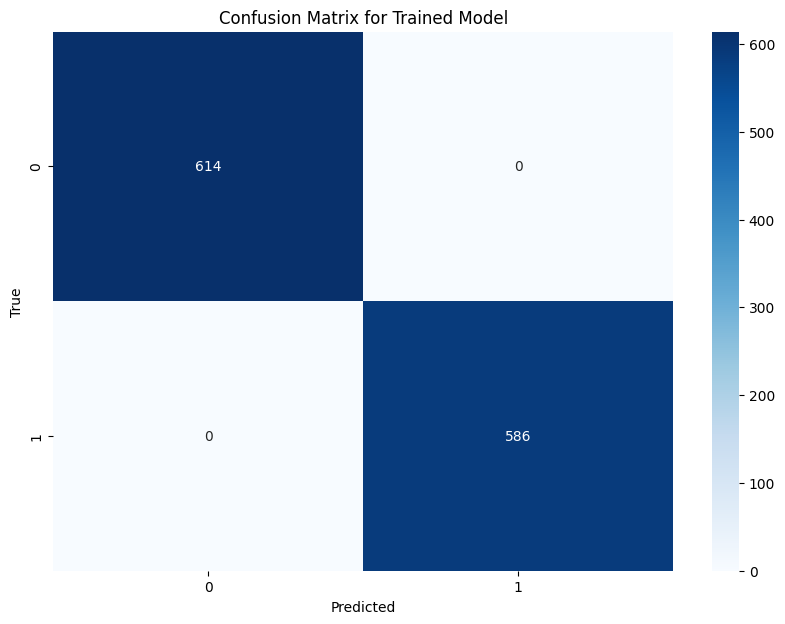

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       614
        True       1.00      1.00      1.00       586

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [39]:
evaluate_model(y_true_trained, y_pred_trained, "Trained Model")
# evaluate_model(y_true_not_trained, y_pred_not_trained, "Not Trained Model")

# Validation

Model: Trained Model


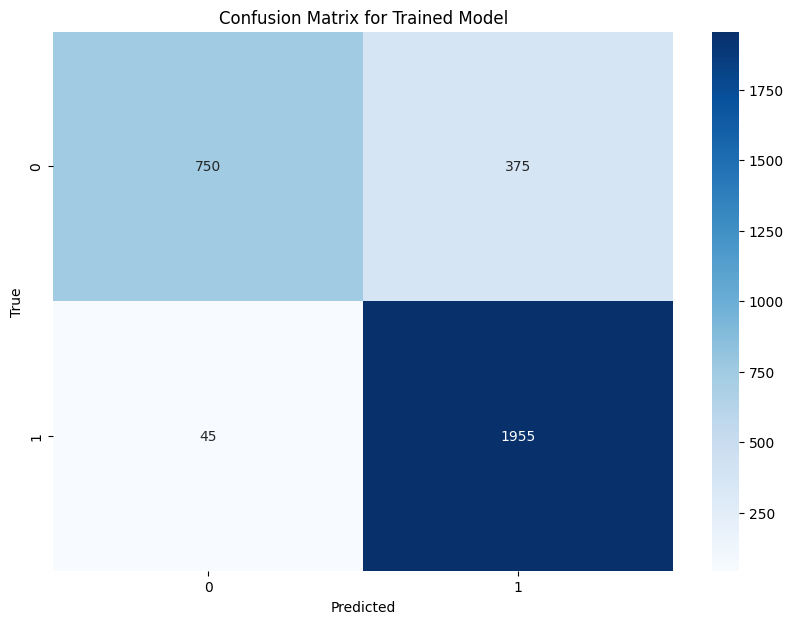

Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.67      0.78      1125
        True       0.84      0.98      0.90      2000

    accuracy                           0.87      3125
   macro avg       0.89      0.82      0.84      3125
weighted avg       0.88      0.87      0.86      3125



In [41]:
# Load validation data
with open('../nlpDataSet/validation.json', 'r') as file:
    validation_data = json.load(file)
nlp_trained = spacy.load("model_is_trip_trained")
validation_data = prepare_data(validation_data)
sentences = [item[0] for item in validation_data]
true_labels = [max(item[1]['cats'], key=item[1]['cats'].get) for item in validation_data]
pred_labels_trained = get_pred_labels(nlp_trained, sentences)
y_true_trained, y_pred_trained = convert_labels(true_labels, pred_labels_trained)

evaluate_model(y_true_trained, y_pred_trained, "Trained Model")